<a href="https://colab.research.google.com/github/CarlosSMWolff/Quantum-Optics-Course/blob/main/5_Two-time-correlation-functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Two-time correlation functions for quantum light-matter systems

In this notebook we will create our custom functions with numpy to simulate an open quantum system

Load necessary packages

In [2]:
# Load numpy for matrix operations
import numpy as np
# Load matplotlib to create plots
import matplotlib.pyplot as plt
from numpy import kron, sqrt, log10, exp, cosh, sinh

import scipy


from tqdm import tqdm

First we build the quantum operators that we use to describe the states and dynamics of the system.

In this example, we have a cavity (annihilation operator $a$) and a two-level system (lowering operator $\sigma$).

We will use the notation "red" for operators that act on the respective spaces of the cavity or the TLS alone, not in the global space that is a tensor product of both.

## Operators

In [3]:
# Define the annihilation operator for a single HO
ncav = 5 # Truncation number: i.e. number of levels of the HO included.
ared = np.diag(np.sqrt(np.arange(1,ncav)),k=1)

# Define the annihilation operator for a TLS
sigmared = np.array([[0,1],[0,0]])



Remember that we work in a Hilbert space which is a tensor product of the cavity Hilbert space and the TLS Hilbert space. Therefore, to build the operators we need to also build tensor products of the reduced operators defined above, for instance:

$$a_\text{total} = a_\text{cavity}\otimes I_{\text{TLS}} $$ 
$$\sigma_\text{total} = I_\text{cavity}\otimes \sigma_{\text{TLS}} $$

This tensor product is performed with numpy's Kronecker product ``np.kron``. The identity is created with ``np.eye``.



In [4]:
a = np.kron(ared,np.eye(2))
sigma = np.kron(np.eye(ncav),sigmared)

h = len(a)
print(f"The size of our combined Hilbert space is {h}")

The size of our combined Hilbert space is 10


# $g^{(2)}(\tau)$ of resonance fluorescence

First we will explore the delayed second-order correlation function for resonance fluorescence (i.e. a coherently driven qubit). 
Therefore, we set aside the cavity for now setting ```g=0``` (if would be more efficient to define a new, reduced system, but let's just do this for convenience)

In [5]:
g = 0.

Omega = 1. + 0.*1j
kappa = 1.+ 0.*1j
gamma = 1.+ 0.*1j


Delta = 0


In [6]:
def lindblad(op):
  id = np.eye(len(op))
  return 1/2*(2*kron(op,op)-kron(op.T@op,id)-kron(id,op.T@op))

def gen_liouvillian(H,c_ops):
  h = len(H)
  id = np.eye(h)

  LH = -1j*(kron(H,id) - kron(id,H)) 
  L = LH
  for op in c_ops:
    L = L + lindblad(op)
  return L


def steadystate_np(H,c_ops: list):
  h = len(H)
  id = np.eye(h)
  LH = -1j*(kron(H,id) - kron(id,H)) 
  L = LH


  for op in c_ops:
    L = L + lindblad(op)

  Lnew = L.copy()
  Lnew[0,:] = (np.eye(h)).flatten()
  ind = np.zeros(h**2); ind[0]=1

  rhoss = np.linalg.solve(Lnew,ind)
  rhossM = np.reshape(rhoss,(h,h))
  
  return rhossM

def gen_Hamiltonian(Delta, g, Omega):
  H = Delta*(a.T@a + sigma.T@sigma) + g*(a.T@sigma + a@sigma.T) + Omega*(sigma + sigma.T)
  return H

In [7]:
taufin = 10; ntau = 100
taugrid = np.linspace(0., taufin, ntau)


In [8]:
H = gen_Hamiltonian(Delta, g, Omega)
c_ops = [sqrt(kappa)*a, sqrt(gamma)*sigma]

rhoSS = steadystate_np(H, c_ops)
L = gen_liouvillian(H,c_ops)

In [9]:
g2tau = []
nq = np.real(np.trace(sigma.T @ sigma @ rhoSS))

for tau in tqdm(taugrid):
  rhs = (sigma@rhoSS@sigma.T).flatten()
  expL = scipy.linalg.expm(L*tau)
  G2 = np.real(np.trace(sigma.T@sigma @ np.reshape(expL @ rhs ,(h,h))))
  g2tau.append(G2/nq**2)

100%|██████████| 100/100 [00:01<00:00, 69.87it/s]


We confirm that our numerical result matches our analytical expression (see notes)

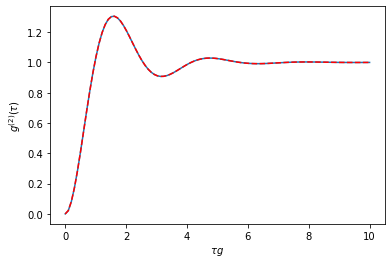

In [10]:
def g2_eq(gamma, Omega, tau):
  delta = sqrt(gamma**2 - 64*Omega**2)/4
  return 1 - exp(-3*gamma*tau/4)*(cosh(delta*tau) + 3*sinh(delta*tau)/(4*delta))

plt.plot(taugrid, g2tau)
plt.plot(taugrid, np.real(g2_eq(gamma, Omega, taugrid)), 'r--')
plt.xlabel('$\\tau g$')
plt.ylabel('$g^{(2)}(\\tau)$')
plt.show()

# $g^{(2)}(\tau)$ of Jaynes Cummings in photon blockade regime

We can now do the same in a full JC system setting $g\neq 0$.
Let's compute the g2 in the photon blockade regime, i.e. with $\Delta = g$.
We will also change the Hamiltonian into cavity driving instead of qubit driving.

In [36]:
g = 1.
Delta = g

Omega = 0.001
kappa = 4.1/33.9 
gamma = 2.6/33.9

In [37]:
def gen_Hamiltonian_JC(Delta, g, Omega):
  H = Delta*(a.T@a + sigma.T@sigma) + g*(a.T@sigma + a@sigma.T) + Omega*(a + a.T)
  return H

In [38]:
taufin = 100; ntau = 500
taugrid = np.linspace(0., taufin, ntau)


In [39]:
H = gen_Hamiltonian_JC(Delta, g, Omega)
c_ops = [sqrt(kappa)*a, sqrt(gamma)*sigma]
rhoSS = steadystate_np(H, c_ops)
L = gen_liouvillian(H,c_ops)

We will now compute the g2 for the emission coming out of the cavity, not the TLS

In [41]:
g2tau = []
na = np.real(np.trace(a.T @ a @ rhoSS))
rhs = (a@rhoSS@a.T).flatten()

for tau in tqdm(taugrid):
  expL = scipy.linalg.expm(L*tau)
  G2 = np.real(np.trace(a.T@a @ np.reshape(expL @ rhs ,(h,h))))
  g2tau.append(G2/na**2)

100%|██████████| 500/500 [00:08<00:00, 59.66it/s]


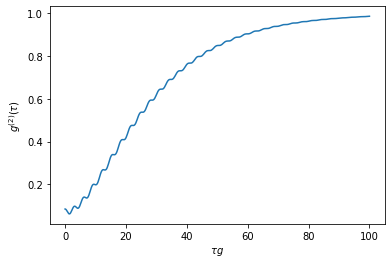

In [43]:
plt.plot(taugrid, g2tau)
plt.xlabel('$\\tau g$')
plt.ylabel('$g^{(2)}(\\tau)$')
plt.show()

FASTER WAY: Since my interval of taus has regular $d\tau$, I can simply evaluate $U(d\tau)=e^{ L d\tau}$ and apply that repeatedly. This way, the evaluation of a matrix exponential is done only once, and not in very iteration of the loop.

In [44]:
g2tau = []
na = np.real(np.trace(a.T @ a @ rhoSS))
rhs = (a@rhoSS@a.T).flatten()

dtau = taugrid[1]-taugrid[0]
Udt = scipy.linalg.expm(L*dtau)

In [45]:
for tau in tqdm(taugrid):
  G2 = np.real(np.trace(a.T@a @ np.reshape(rhs ,(h,h))))
  rhs = Udt@rhs
  g2tau.append(G2/na**2)

100%|██████████| 500/500 [00:00<00:00, 7685.99it/s]


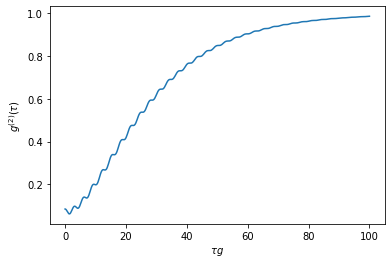

In [46]:
plt.plot(taugrid, g2tau)
plt.xlabel('$\\tau g$')
plt.ylabel('$g^{(2)}(\\tau)$')
plt.show()

What about other system parameters?

In [47]:
Delta = g/2

In [49]:
H = gen_Hamiltonian_JC(Delta, g, Omega)
c_ops = [sqrt(kappa)*a, sqrt(gamma)*sigma]
rhoSS = steadystate_np(H, c_ops)
L = gen_liouvillian(H,c_ops)

g2tau = []
na = np.real(np.trace(a.T @ a @ rhoSS))
rhs = (a@rhoSS@a.T).flatten()

dtau = taugrid[1]-taugrid[0]
Udt = scipy.linalg.expm(L*dtau)

for tau in tqdm(taugrid):
  G2 = np.real(np.trace(a.T@a @ np.reshape(rhs ,(h,h))))
  rhs = Udt@rhs
  g2tau.append(G2/na**2)

100%|██████████| 500/500 [00:00<00:00, 20882.98it/s]


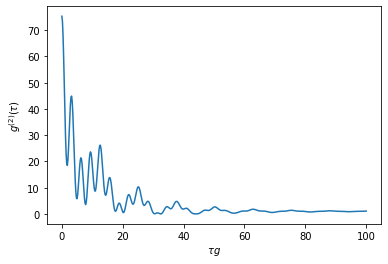

In [50]:
plt.plot(taugrid, g2tau)
plt.xlabel('$\\tau g$')
plt.ylabel('$g^{(2)}(\\tau)$')
plt.show()